In [2]:
import os
import glob
import re
import ants

import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

in_container=True
DATADIR = "/DATA" if in_container else "/BEE/Connectome"
raw_data_path = "/ASD2/ahsan_projects/datasets/BRATS2023-PED/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/"
processed_data_path = f"/{DATADIR}/Users/amahmood/braintyp/brats-gli/"
segs_dir = f"/{DATADIR}/Users/amahmood/braintyp/segs/"

In [3]:
%ls -ailh $processed_data_path | grep BraTS | head

12943583227 -rw-r--r--.  1 amahmood 1001 9.6M Oct 25 18:35 BraTS-GLI-00000-000.nii.gz
12943583229 -rw-r--r--.  1 amahmood 1001  41K Oct 25 18:35 BraTS-GLI-00000-000_label.nii.gz
12959716643 -rw-r--r--.  1 amahmood 1001 9.0M Oct 25 20:36 BraTS-GLI-00002-000.nii.gz
12959716645 -rw-r--r--.  1 amahmood 1001  50K Oct 25 20:36 BraTS-GLI-00002-000_label.nii.gz
12941230687 -rw-r--r--.  1 amahmood 1001  11M Oct 25 18:17 BraTS-GLI-00003-000.nii.gz
12942129986 -rw-r--r--.  1 amahmood 1001  44K Oct 25 18:17 BraTS-GLI-00003-000_label.nii.gz
12939292275 -rw-r--r--.  1 amahmood 1001 8.3M Oct 25 17:45 BraTS-GLI-00005-000.nii.gz
12939292278 -rw-r--r--.  1 amahmood 1001  47K Oct 25 17:45 BraTS-GLI-00005-000_label.nii.gz
12941256422 -rw-r--r--.  1 amahmood 1001 9.8M Oct 25 18:00 BraTS-GLI-00006-000.nii.gz
12941256425 -rw-r--r--.  1 amahmood 1001  48K Oct 25 18:00 BraTS-GLI-00006-000_label.nii.gz
grep: write error: Broken pipe
ls: write error


In [4]:
# dirs = glob.glob(f"{raw_data_path}/*/*")
# ages = [p.split("/")[-1] for p in dirs]
# Counter(ages)

In [3]:
%ls $raw_data_path

ls: cannot access '/ASD2/ahsan_projects/datasets/BRATS2023-PED/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/': No such file or directory


In [ ]:
img,_ = ants.image_read(f"{processed_data_path}/BraTS-GLI-00020-000.nii.gz").split_channels()
img.plot(nslices=6)

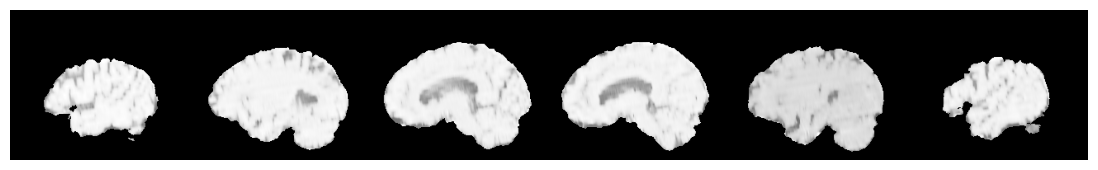

In [6]:
img,_ = ants.image_read(f"{processed_data_path}/BraTS-GLI-00020-000.nii.gz").split_channels()
img.plot(nslices=6)

In [7]:
img.std()

0.28219688

### WM Segmentations fail, so we can use simple heuristics

In [8]:
img_paths = glob.glob(f"{processed_data_path}/BraTS*[0-9].nii.gz")
subids = [re.search(r"(BraTS.*)\.nii", p).group(1) for p in img_paths]
len(img_paths), img_paths[0], subids[0]

(1251,
 '//DATA/Users/amahmood/braintyp/brats-gli/BraTS-GLI-00442-000.nii.gz',
 'BraTS-GLI-00442-000')

In [9]:
%%time
t1_means, t1_stds = [], []
t2_means, t2_stds = [], []

for p in tqdm(img_paths):
    img = ants.image_read(p)
    t1,t2 = img.split_channels()
    t1_means.append(t1.mean())
    t1_stds.append(t1.std())

    t2_means.append(t2.mean())
    t2_stds.append(t2.std())

100%|██████████| 1251/1251 [16:20<00:00,  1.28it/s]

CPU times: user 14min 20s, sys: 31.7 s, total: 14min 52s
Wall time: 16min 20s


In [10]:
t1_wm_means = pd.Series(t1_means, index=subids)
t2_wm_means = pd.Series(t2_means, index=subids)

<Axes: >

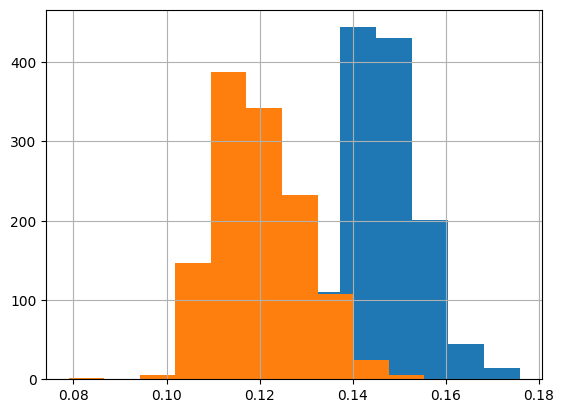

In [11]:
t1_wm_means.hist()
t2_wm_means.hist()

In [12]:
t1_wm_stds = pd.Series(t1_stds, index=subids)
t2_wm_stds = pd.Series(t2_stds, index=subids)

<Axes: >

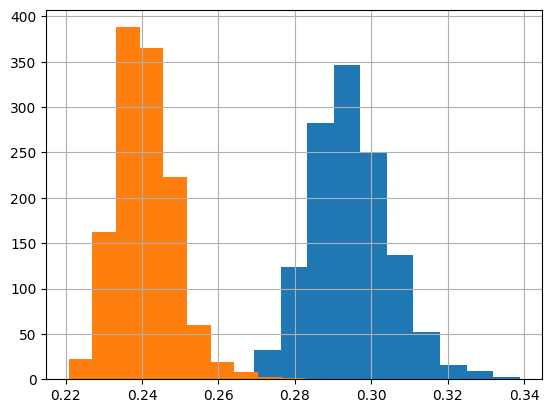

In [13]:
t1_wm_stds.hist()
t2_wm_stds.hist()

In [14]:
t1_mu = t1_wm_means.dropna().mean()
t1_std = t1_wm_means.dropna().std()

print(f"T1 Means: mu: {t1_mu:.3f} w/ std {t1_std:.3f}")

T1 Means: mu: 0.147 w/ std 0.008


In [15]:
t1_stds_mu = t1_wm_stds.mean()
t1_stds_std = t1_wm_stds.std()

print(f"T1 Stds: {t1_stds_mu:.3f} w/ std {t1_stds_std:.3f}")

T1 Stds: 0.295 w/ std 0.010


In [47]:
mult = 2
t1_mu_candidates = (t1_wm_means > (t1_mu + mult*t1_std)) | (t1_wm_means < (t1_mu - mult*t1_std))
t1_std_candidates = (t1_wm_stds > (t1_stds_mu + mult*t1_stds_std)) | (t1_wm_stds < (t1_stds_mu - mult*t1_stds_std))
t1_candidates = t1_mu_candidates | t1_std_candidates
t1_outliers = np.argwhere(t1_candidates.to_numpy()).flatten()
len(t1_outliers)

99

In [25]:
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

1251

BraTS-GLI-01365-000: //DATA/Users/amahmood/braintyp/brats-gli//BraTS-GLI-01365-000.nii.gz


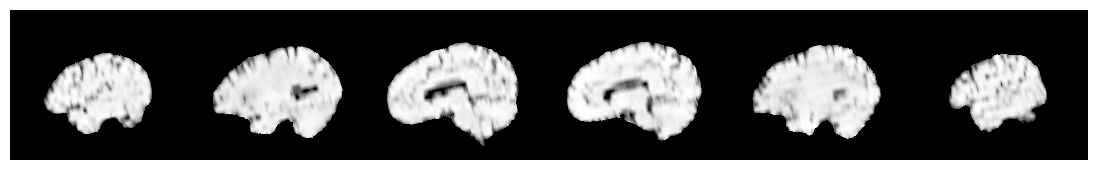

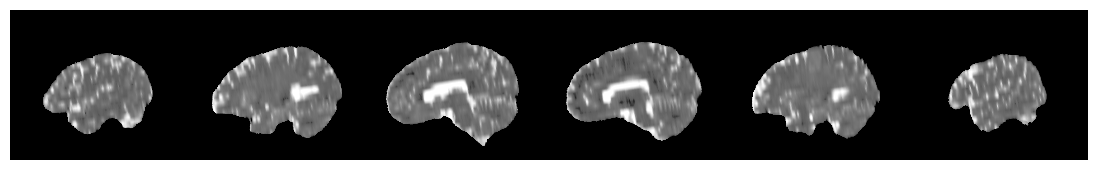

BraTS-GLI-00053-000: //DATA/Users/amahmood/braintyp/brats-gli//BraTS-GLI-00053-000.nii.gz


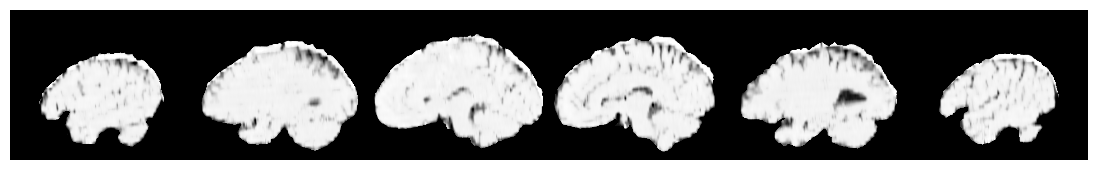

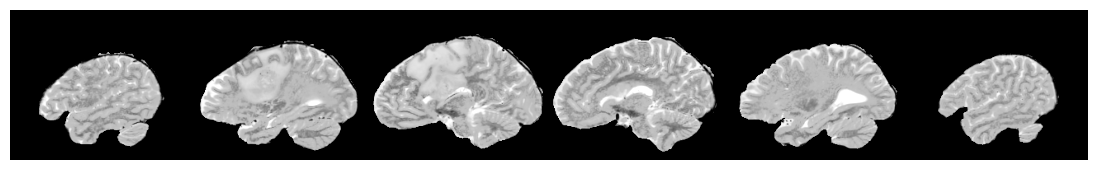

BraTS-GLI-01239-000: //DATA/Users/amahmood/braintyp/brats-gli//BraTS-GLI-01239-000.nii.gz


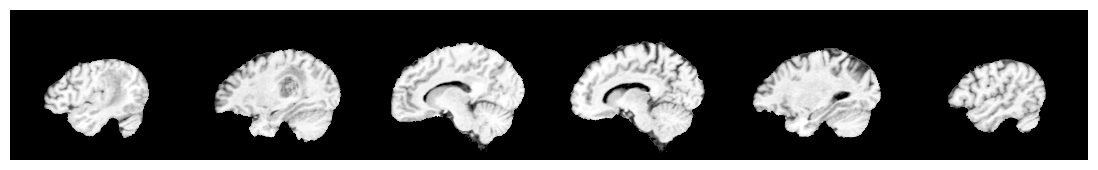

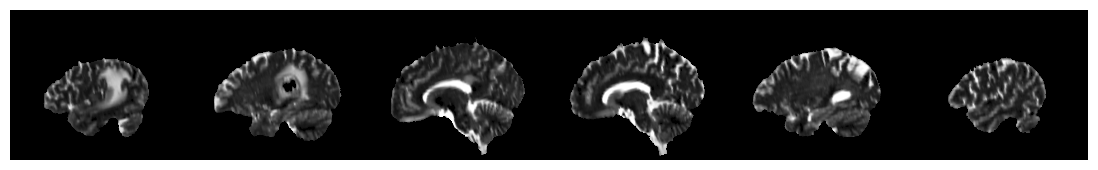

BraTS-GLI-00680-000: //DATA/Users/amahmood/braintyp/brats-gli//BraTS-GLI-00680-000.nii.gz


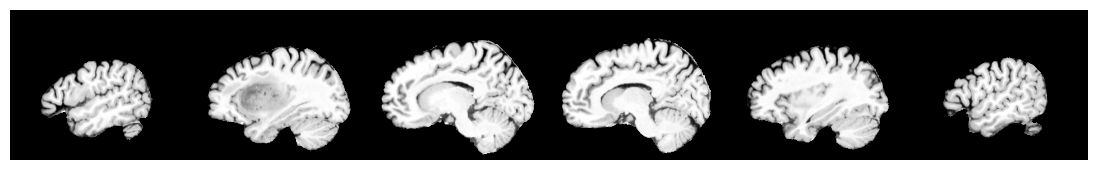

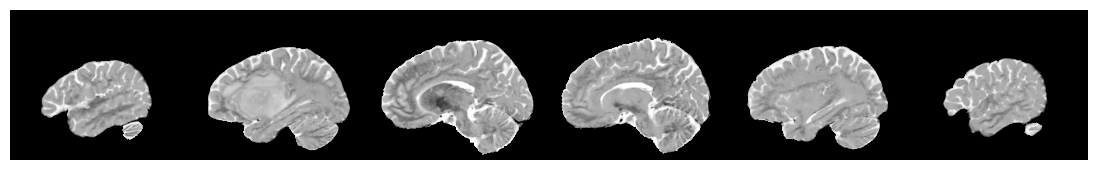

In [48]:
for tidx in t1_outliers[:4]:
    sid = t1_wm_means.index[tidx]
#     path = glob.glob(f"{raw_data_path}/{sid[4:]}/*/anat/*")[-1]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")

    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

### T2

In [49]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [50]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.120 w/ std 0.009


In [51]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.241 w/ std 0.008


In [52]:
mult = 2
t2_mu_candidates = (t2_wm_means > (t2_mu + mult*t2_std)) | (t2_wm_means < (t2_mu - mult*t2_std))
t2_std_candidates = (t2_wm_stds > (t2_stds_mu + mult*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - mult*t2_stds_std))
t2_candidates = t2_mu_candidates | t2_std_candidates
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

85

BraTS-GLI-00053-000: //DATA/Users/amahmood/braintyp/brats-gli//BraTS-GLI-00053-000.nii.gz


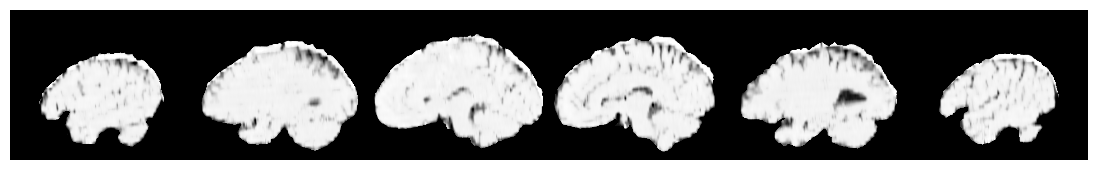

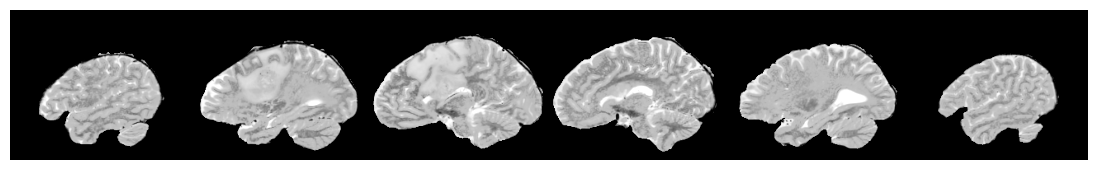

BraTS-GLI-00680-000: //DATA/Users/amahmood/braintyp/brats-gli//BraTS-GLI-00680-000.nii.gz


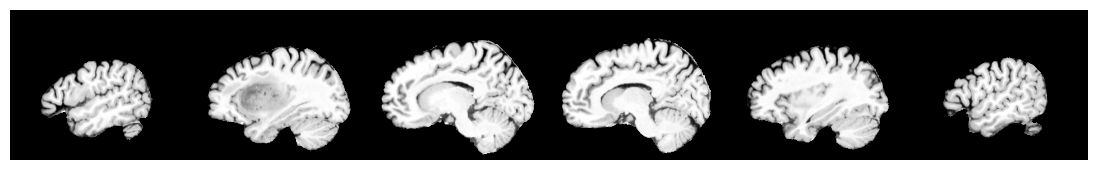

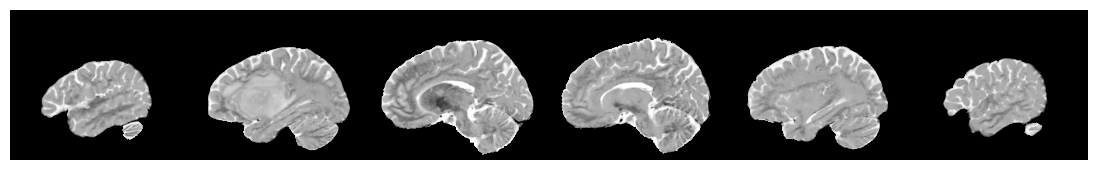

BraTS-GLI-00051-000: //DATA/Users/amahmood/braintyp/brats-gli//BraTS-GLI-00051-000.nii.gz


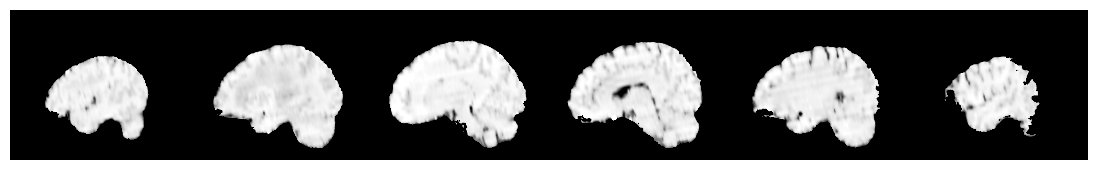

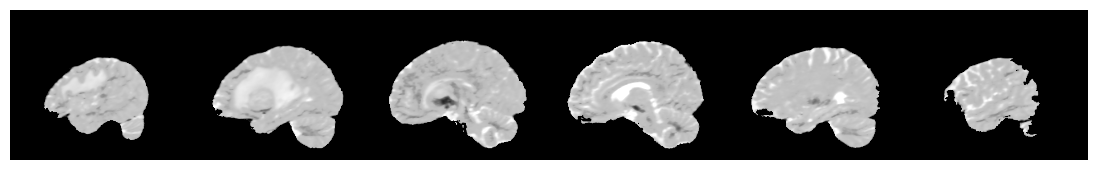

BraTS-GLI-00084-001: //DATA/Users/amahmood/braintyp/brats-gli//BraTS-GLI-00084-001.nii.gz


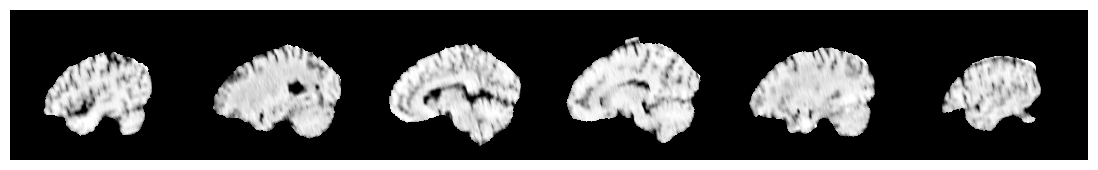

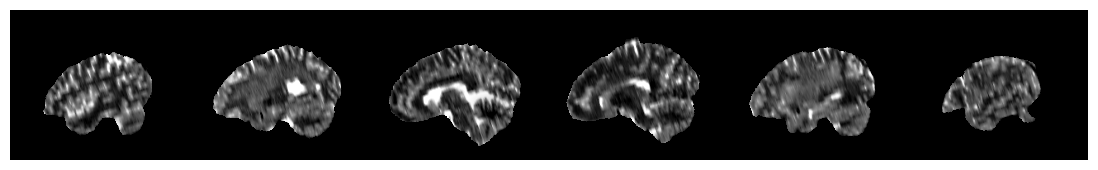

In [53]:
for tidx in t2_outliers[:4]:
    sid = t2_wm_means.index[tidx]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")
    
#     t1_outlier_img = ants.image_read(path)
#     t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))    
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

In [54]:
t1_drop_samples = t1_wm_means.index[t1_outliers].to_list()
t2_drop_samples = t2_wm_means.index[t2_outliers].to_list()
drop_samples = set(t1_drop_samples).union(set(t2_drop_samples))
len(drop_samples)

141

In [62]:
len(t1_wm_means)

1251

In [61]:
keep_samples = t1_wm_means.drop(index=drop_samples).index.to_list()
len(keep_samples)

1110

In [63]:
brats_gli_passing_keys = pd.Series(keep_samples)
brats_gli_passing_keys.to_csv('../split-keys/brats-gli_keys.txt', header=None, index=None)